In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import torch
import glob

import bvcopula

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [97]:
animal = 'ST263'
dayN = 4
day_name = 'Day{}'.format(dayN)
exp_pref = '{}_{}'.format(animal,day_name)
path = '/home/nina/models'

In [98]:
out_dir = '../models/'+exp_pref
with open(out_dir+'/summary.pkl','rb') as f:
    data = pkl.load(f)
n1=2
n2=20
data[n1+5,n2+5][0]

[FrankCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 ), IndependenceCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 ), GumbelCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 )]

In [300]:
import warnings
import sys
import traceback
from tqdm import tqdm
    
def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))
    
def get_model(n1,n2,likelihoods,device):
    get_weights_filename = glob.glob('{}/{}/model_{}-{}.pth'.format(path,exp_pref,n1,n2))
    print(get_weights_filename)
    if len(get_weights_filename)>0:
        if len(get_weights_filename)>1:
            print('There is more then 1 file, taking the first one')
            return 0
        model = bvcopula.load_model(get_weights_filename[0], likelihoods, device)
        return model
    else:
        print('Weights file {} not found.'.format(get_weights_filename))
        return 0
        
def measure_MI(model,points,samp_mc_size=10000):
    MIs = []
    with torch.no_grad():
        fs = model(points).rsample(torch.Size([5])) #[samples_f, copulas, positions]
    f_mean = model(points).mean.unsqueeze(0)
    # now add mean f to a set of f samples
    fs = torch.cat((fs,f_mean),0) #[samples_f + 1, copulas, positions]

    copula = model.likelihood(fs)
    MIs = copula.entropy()
    MI_mean = MIs[-1]
    MIs = MIs[:-1]

    return (MI_mean,MIs.mean(dim=0),MIs.std(dim=0))

warnings.showwarning = warn_with_traceback

points = torch.linspace(0,1,20)
        
n1=1
n2=4

print(data[n1+5,n2+5][1])

%time model = get_model(n1, n2, data[n1+5,n2+5][0], torch.device('cpu')) 
%time (ym, y, dy) = measure_MI(model, points)

FrankGaussian
['/home/nina/models/ST263_Day4/model_1-4.pth']
CPU times: user 312 ms, sys: 0 ns, total: 312 ms
Wall time: 12.1 ms
CPU times: user 14min 9s, sys: 1.25 s, total: 14min 10s
Wall time: 26.7 s


(-0.5, 0)

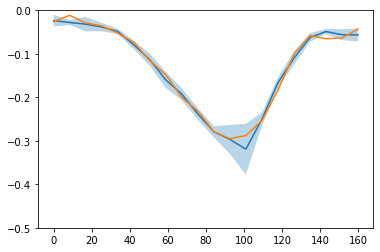

In [301]:
plt.plot(np.linspace(0,160,len(y)),y)
plt.fill_between(np.linspace(0,160,len(y)),y-dy,y+dy, alpha=0.3)
plt.plot(np.linspace(0,160,len(ym)),ym)
plt.ylim(-.5,0)

In [783]:
def stimMI(copula, pS=None, alpha=0.05, sem_tol=1e-3, mc_size=10000):
    '''
    Estimates the mutual information between a pair of uniformely
    distributed copula-transformed variables and the conditioning variable
    with the Robbins-Monro algorithm over responses.
    Parameters
    ----------
    pS : Tensor
        Prior over stimuli P(S). TODO: this, now assume uniform!
    alpha : float, optional
        Significance level of the entropy estimate.  (Default: 0.05)
    sem_tol : float, optional
        Maximum standard error as a stopping criterion.  (Default: 1e-3)
    mc_size : integer, optional
        Number of samples that are drawn in each iteration of the Monte
        Carlo estimation.  (Default: 10000)
    Returns
    -------
    ent : float
        Estimate of the mixed vine entropy in bits.
    sem : float
        Standard error of the mixed vine entropy estimate in bits.
    '''
    # Gaussian confidence interval for sem_tol and level alpha
    conf = torch.erfinv(torch.tensor([1. - alpha]))
    batch_shape = copula.batch_shape[1:] #first dm is number of copulas, discard it
    #assume that batch_shape = [samples_f shape x conditional variable]
    
    ds = 1/(batch_shape[-1])
    if pS is None:
        pS = torch.ones(batch_shape[-1])*ds
    assert pS.dim() == 1
    assert pS.shape[0] == batch_shape[-1]
    assert torch.allclose(pS.sum(),torch.ones(1))
    pS_ = pS.expand([mc_size*batch_shape[-1],*batch_shape])

    sem = torch.ones(batch_shape)*float('inf')
    MI = torch.zeros(batch_shape) #theta here must have dims: fs x batch dims
    var_sum = torch.zeros(batch_shape)
    log2 = torch.tensor([2.]).log()
#     x, y = [torch.tensor(i) for i in np.mgrid[0:mc_size,0:batch_shape[1]]]
#     perm = torch.randperm(mc_size * batch_shape[1]) #premutations for samples x positions
#     x_ = x.view(-1)[perm]
#     y_ = y.view(-1)[perm]
    k = 0
    with torch.no_grad():
        while torch.any(sem >= sem_tol):
            # Generate samples
            samples = copula.rsample(sample_shape = torch.Size([mc_size]))
            # size [samples, fs, positions, 2]
            samples = torch.einsum("ijk...->ikj...",samples) # samples x Xs x fs x 2
            samples = samples.reshape(-1,*samples.shape[2:]) # (samples * Xs) x fs x 2
            samples = samples.unsqueeze(dim=-2) # (samples * Xs) x fs x 1 x 2
            samples = samples.expand([mc_size*batch_shape[-1],*batch_shape,2]) # (samples * Xs) x fs x Xs x 2
            # now these are samples from p(s,r)
            logpRgS = copula.log_prob(samples) # [sample dim, batch dims]
            logpR = ((logpRgS.exp()*pS_).sum(dim=-1)).log() # sum over stimuli p(r) = sum p(r|s) p(s)
            # *ds -> mass function
            assert torch.all(logpR==logpR)
            assert torch.all(logpR.abs()!=float("inf"))
            log2p = (logpRgS - logpR.unsqueeze(-1)) / log2 #maybe should check for inf 2 lines earlier
            k += 1
            if k>100:
                print('MC integral failed to converge')
                break
            # Monte-Carlo estimate of entropy
            MI += ((pS_*log2p).mean(dim=0) - MI) / k # mean over samples dimension
            # Estimate standard error
            var_sum += ((((pS_*log2p) - MI)) ** 2).sum(dim=0) 
            sem = conf * (var_sum / (k * mc_size*batch_shape[-1] * (k * mc_size*batch_shape[-1] - 1))).pow(.5)
            #print(MI.sum(dim=-1).mean())
            print(sem.max()/sem_tol)
    return MI#, sem


In [785]:
def measure_MI(model,points,pS=None,r_mc_size=1000,f_mc_size=10,sem_tol=1e-3):
    MIs = []
    with torch.no_grad():
        fs = model(points).rsample(torch.Size([f_mc_size])) #[samples_f, copulas, positions]
    #fs = fs.expand([f_mc_size,*fs.shape[1:]])
    copula = model.likelihood(fs)
    MI = stimMI(copula, pS=pS, sem_tol=sem_tol, mc_size=r_mc_size)
    if pS is not None:
        plt.imshow(MI/pS.expand(MI.shape))
    MIs = MI.sum(dim=-1)

    return (MIs.mean(dim=0),MIs.std(dim=0))

warnings.showwarning = warn_with_traceback

points = torch.linspace(0,1,100)

print(data[n1+5,n2+5][1])

model = get_model(n1, n2, data[n1+5,n2+5][0], torch.device('cpu')) 
%time (MI, dMI) = measure_MI(model, points)
print(MI,dMI)

FrankGaussian
['/home/nina/models/ST263_Day4/model_1-4.pth']
tensor(0.0264)
CPU times: user 2min, sys: 1min 8s, total: 3min 8s
Wall time: 23.9 s
tensor(-0.0250) tensor(0.0013)


In [786]:
import utils
path_exp = '/home/nina/VRData/Processing/pkls'
X,_ = utils.load_experimental_data(path_exp, animal, day_name, 0, 1)

(array([1.00005097, 1.20006116, 0.80004078, 0.50002549, 0.80004078,
        1.00005097, 0.40002039, 1.00005097, 1.60008155, 1.70008665]),
 array([4.98294435e-05, 1.00044733e-01, 2.00039636e-01, 3.00034539e-01,
        4.00029442e-01, 5.00024345e-01, 6.00019249e-01, 7.00014152e-01,
        8.00009055e-01, 9.00003958e-01, 9.99998861e-01]),
 <a list of 10 Patch objects>)

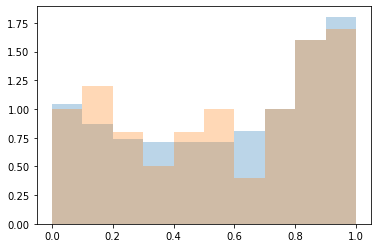

In [787]:
plt.hist(X,density=True,alpha=0.3)
plt.hist(np.random.choice(X.flatten(),100),density=True,alpha=0.3)

1.0730882676735007


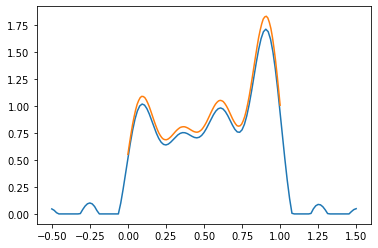

In [791]:
from fastkde import fastKDE

subset_X = np.random.choice(X.flatten(),500)

cOfX,axis = fastKDE.pdf(subset_X);

plt.plot(axis,cOfX)

def transform_point(x):
    f_x = np.sum(axis<x)
    wx = np.abs((axis[f_x]-x)/(axis[f_x]-axis[f_x-1]))
    return (1-wx)*cOfX[f_x] + wx*cOfX[f_x-1]

x = np.linspace(0,1,100)
y = np.array([transform_point(i) for i in x])
k = len(x)/y.sum()
print(k)
y = y*k
plt.plot(x,y)

In [793]:
subset_X = np.sort(subset_X)
model = get_model(n1, n2, data[n1+5,n2+5][0], torch.device('cpu')) 
points = torch.linspace(0,1,len(subset_X)).float()
#pS = torch.ones(len(points))*1/(len(points))
pS = torch.tensor([transform_point(i) for i in subset_X]).float()
pS = pS/pS.sum()
%time (MI, dMI) = measure_MI(model, points, pS=pS, f_mc_size=20)
print(MI,dMI)
points = torch.tensor(subset_X).float()
%time (MI, dMI) = measure_MI(model, points, pS=None, f_mc_size=20)
print(MI,dMI)

['/home/nina/models/ST263_Day4/model_1-4.pth']


RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 118464000000 bytes. Error code 12 (Cannot allocate memory)


tensor(-0.0250) tensor(0.0013)


RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 117960000000 bytes. Error code 12 (Cannot allocate memory)


tensor(-0.0250) tensor(0.0013)


In [862]:
def stimMIm(model, X, alpha=0.05, sem_tol=1e-3, 
         f_mc_size=5, s_mc_size=100, r_mc_size=1000):
    # Gaussian confidence interval for sem_tol and level alpha
    conf = torch.erfinv(torch.tensor([1. - alpha]))
    sem = torch.ones(f_mc_size)*float('inf')
    MI = torch.zeros(f_mc_size)
    var_sum = torch.zeros(f_mc_size)
    log2 = torch.tensor([2.]).log()
    k = 0
    N = r_mc_size*s_mc_size
    with torch.no_grad():
        while torch.any(sem >= sem_tol):
            # Sample from p(s)
            subset_X = np.random.choice(X.flatten(),s_mc_size)
            points = torch.linspace(0,1,len(subset_X)).float()
            with torch.no_grad():
                fs = model(points).rsample(torch.Size([f_mc_size])) 
                #[samples_f, copulas, stimuli(positions)]
            copula = model.likelihood(fs)
            # Generate samples from p(r|s)*p(s)
            samples = copula.rsample(sample_shape = torch.Size([r_mc_size]))
            # these are samples for p(r|s) for all s
            # size [samples, fs, stimuli(positions), 2] = [r,f,s,2]
            samples = torch.einsum("ijk...->ikj...",samples) # samples x Xs x fs x 2
            samples = samples.reshape(-1,*samples.shape[2:]) # (samples * Xs) x fs x 2
            samples = samples.unsqueeze(dim=-2) # (samples * Xs) x fs x 1 x 2
            samples = samples.expand([N,f_mc_size,s_mc_size,2]) # (samples * Xs) x fs x Xs x 2
            # now these are samples_ from p(r)
            logpRfS = copula.log_prob(samples) # [r for all s,f,s]
            logpR = ((logpRfS.exp()*(1/s_mc_size)).sum(dim=-1)).log() # sum over stimuli p(r) = sum p(r|s) p(s)
            logpRgS = logpRfS[::s_mc_size] # [r|s,f,s]
            logpRgS = torch.einsum("ijk->ikj",logpRgS)
            logpRgS = logpRgS.reshape(-1,*logpRgS.shape[2:])
            assert torch.all(logpR==logpR)
            assert torch.all(logpR.abs()!=float("inf"))
            log2p = (logpRgS - logpR) / log2
            k += 1
            if k>100:
                print('MC integral failed to converge')
                break
            # Monte-Carlo estimate of entropy
            MI += (log2p.mean(dim=0) - MI) / k # mean over r&s dimensions -> [f]
            # Estimate standard error
            var_sum += ((log2p - MI) ** 2).sum(dim=0) 
            sem = conf * (var_sum / (k * N * (k * N - 1))).pow(.5)
            print(MI.mean(),sem.max()/sem_tol)
    return MI

def stimMIc(copula, alpha=0.05, sem_tol=1e-3, r_mc_size=200):
    # Gaussian confidence interval for sem_tol and level alpha
    conf = torch.erfinv(torch.tensor([1. - alpha]))
    batch_shape = copula.batch_shape[1:] # [f,s]
    sem = torch.ones(batch_shape[0])*float('inf')
    MI = torch.zeros(batch_shape[0])
    var_sum = torch.zeros(batch_shape[0])
    log2 = torch.tensor([2.]).log()
    k = 0
    Ns = batch_shape[-1]
    N = r_mc_size*Ns
    with torch.no_grad():
        while torch.any(sem >= sem_tol):
            # Generate samples from p(r|s)*p(s)
            samples = copula.rsample(sample_shape = torch.Size([r_mc_size]))
            # these are samples for p(r|s) for all s
            # size [samples, fs, stimuli(positions), 2] = [r,f,s,2]
            samples = torch.einsum("ijk...->ikj...",samples) # samples x Xs x fs x 2
            samples = samples.reshape(-1,*samples.shape[2:]) # (samples * Xs) x fs x 2
            samples = samples.unsqueeze(dim=-2) # (samples * Xs) x fs x 1 x 2
            samples = samples.expand([N,*batch_shape,2]) # (samples * Xs) x fs x Xs x 2
            # now these are samples_ from p(r)
            logpRfS = copula.log_prob(samples) # [r for all s,f,s]
            logpR = ((logpRfS.exp()*(1/Ns)).sum(dim=-1)).log() # sum over stimuli p(r) = sum p(r|s) p(s)
            logpRgS = logpRfS[::Ns] # [r|s,f,s]
            logpRgS = torch.einsum("ijk->ikj",logpRgS)
            logpRgS = logpRgS.reshape(-1,*logpRgS.shape[2:])
            assert torch.all(logpR==logpR)
            assert torch.all(logpR.abs()!=float("inf"))
            log2p = (logpRgS - logpR) / log2
            k += 1
            if k>100:
                print('MC integral failed to converge')
                break
            # Monte-Carlo estimate of entropy
            MI += (log2p.mean(dim=0) - MI) / k # mean over r&s dimensions -> [f]
            # Estimate standard error
            var_sum += ((log2p - MI) ** 2).sum(dim=0) 
            sem = conf * (var_sum / (k * N * (k * N - 1))).pow(.5)
            print(MI.mean(),sem.max()/sem_tol)
    return MI

In [863]:
n1=1
n2=12
model = get_model(n1, n2, data[n1+5,n2+5][0], torch.device('cpu')) 
%time MI=stimMIm(model, X)
print(MI.mean(),MI.std())

['/home/nina/models/ST263_Day4/model_1-12.pth']
tensor(0.2235) tensor(5.6670)
tensor(0.2012) tensor(4.0347)
tensor(0.2050) tensor(3.2565)
tensor(0.2100) tensor(2.8193)
tensor(0.2132) tensor(2.4765)
tensor(0.2039) tensor(2.2614)
tensor(0.2075) tensor(2.0717)
tensor(0.2072) tensor(1.9452)
tensor(0.2008) tensor(1.8236)
tensor(0.1990) tensor(1.7314)
tensor(0.1998) tensor(1.6495)
tensor(0.2007) tensor(1.5784)
tensor(0.1976) tensor(1.5138)
tensor(0.1964) tensor(1.4592)
tensor(0.1953) tensor(1.4024)
tensor(0.1941) tensor(1.3547)
tensor(0.1917) tensor(1.3142)
tensor(0.1910) tensor(1.2818)
tensor(0.1901) tensor(1.2457)
tensor(0.1906) tensor(1.2148)
tensor(0.1917) tensor(1.1830)
tensor(0.1921) tensor(1.1543)
tensor(0.1922) tensor(1.1277)
tensor(0.1931) tensor(1.1083)
tensor(0.1943) tensor(1.0841)
tensor(0.1946) tensor(1.0597)
tensor(0.1933) tensor(1.0398)
tensor(0.1921) tensor(1.0201)
tensor(0.1930) tensor(1.0011)
tensor(0.1947) tensor(0.9847)
CPU times: user 36min, sys: 14min 54s, total: 50min 

In [864]:
n1=1
n2=12
model = get_model(n1, n2, data[n1+5,n2+5][0], torch.device('cpu')) 
subset_X = np.random.choice(X.flatten(),100)
points = torch.linspace(0,1,len(subset_X)).float()
with torch.no_grad():
    fs = model(points).rsample(torch.Size([10])) 
    #[samples_f, copulas, stimuli(positions)]
copula = model.likelihood(fs)
print('Starting')
%time MI=stimMIc(copula)
print(MI.mean(),MI.std())

['/home/nina/models/ST263_Day4/model_1-12.pth']
Starting
tensor(0.1644) tensor(12.2158)
tensor(0.1472) tensor(8.7889)
tensor(0.1658) tensor(7.5689)
tensor(0.1574) tensor(6.3350)
tensor(0.1625) tensor(5.5878)
tensor(0.1649) tensor(5.0841)
tensor(0.1590) tensor(4.7332)
tensor(0.1597) tensor(4.4180)
tensor(0.1673) tensor(4.1531)
tensor(0.1687) tensor(3.9494)
tensor(0.1765) tensor(3.7340)
tensor(0.1772) tensor(3.5890)
tensor(0.1804) tensor(3.4296)
tensor(0.1836) tensor(3.3163)
tensor(0.1872) tensor(3.1922)
tensor(0.1895) tensor(3.0775)
tensor(0.1885) tensor(2.9764)
tensor(0.1899) tensor(2.8943)
tensor(0.1882) tensor(2.8084)
tensor(0.1884) tensor(2.7445)
tensor(0.1902) tensor(2.6799)
tensor(0.1891) tensor(2.6226)
tensor(0.1896) tensor(2.5649)
tensor(0.1896) tensor(2.5225)
tensor(0.1891) tensor(2.4781)
tensor(0.1879) tensor(2.4223)
tensor(0.1883) tensor(2.3860)
tensor(0.1886) tensor(2.3460)
tensor(0.1888) tensor(2.3039)
tensor(0.1875) tensor(2.2564)
tensor(0.1865) tensor(2.2169)
tensor(0.185

In [716]:
def input_information(model, n: int, scale: float, samp_mc_size=100, device=torch.device('cpu')):
        ds = scale/n #scale determines units of ds
        
        points = torch.linspace(0,1,n+3)

        with torch.no_grad():
            fs = model(points).rsample(torch.Size([20])) #[samples_f, copulas, positions]
        fs = torch.einsum('ijk->jki', fs) #[copulas, positions, samples_f] 
        f = fs.reshape((fs.shape[0],-1)) #[copulas, (samples_f x positions)]
            
        copula = model.likelihood._get_copula(f, sample_size = torch.Size([samp_mc_size]))
        samples = copula.rsample()
        logprob = copula.log_prob(samples)
        
        logprob = logprob.reshape((*fs.shape[1:],-1)) #[positions, samples_f]

        #calculate FI
        FI = torch.zeros_like(logprob[...,0])
        for i in range(1,n):
            FI[i] = ((logprob[i].exp())*((logprob[i+1]-logprob[i-1])/ds).pow(2)).sum(dim=-1)
            if (i>2) & (i<n-1):
                
#             #now calculate MI    
#             # P(r) = integral P(r|s) P(s) ds
#             Pr = torch.zeros(samples.shape[0]).cuda(device=get_cuda_device)
#             for i in range(n+1):
#                 Pr += logprob[i].exp().detach()*(1/(n+1))
#             MIs=0
#             for i in range(n+1):    
#                 MIs+= 1/(n+1)*logprob[i].exp()*(logprob[i]-Pr.log()) # sum p(r|s) * log p(r|s)/p(r)
#             MI = MIs.sum()     
        return (FI.mean(dim=-1),FI.std(dim=-1))

model = get_model(n1, n2, data[n1+5,n2+5][0], torch.device('cpu')) 
%time (FI, dFI) = input_information(model, 160, 160, device=torch.device('cpu'))

IndentationError: expected an indented block (<ipython-input-716-1edd0510d82b>, line 32)

In [ ]:
plt.plot(np.linspace(0,160,len(FI)),FI)
plt.fill_between(np.linspace(0,160,len(FI)),FI-dFI,FI+dFI, alpha=0.3)